In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

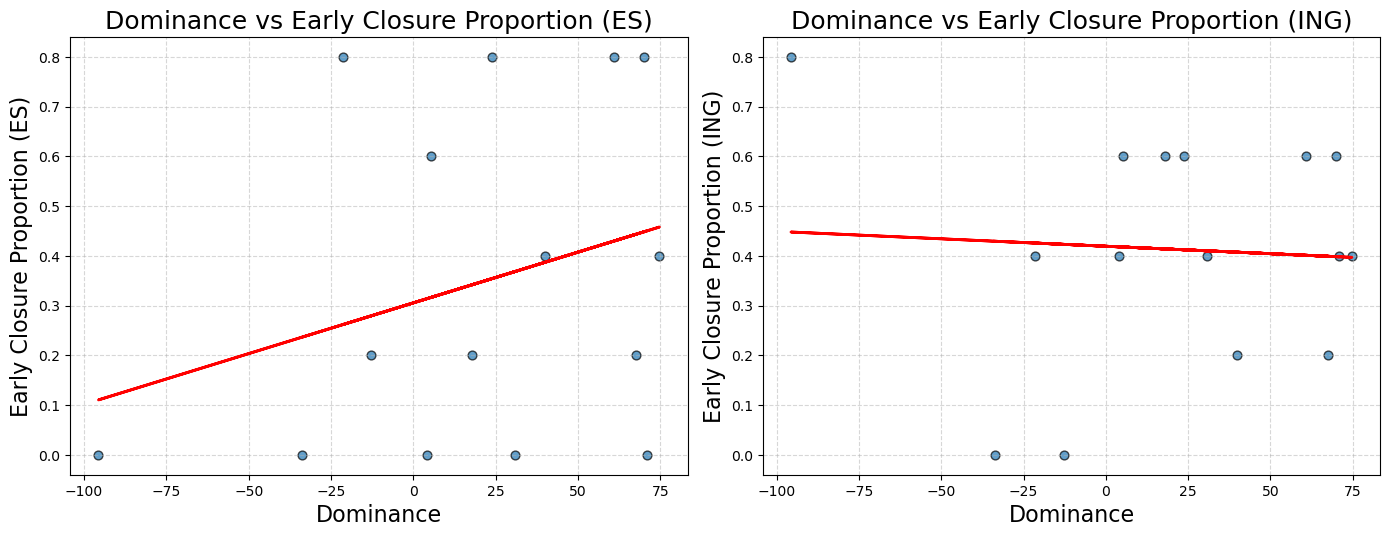

In [7]:
merged_df = pd.read_csv("data/merged.csv")

merged_df['Dominance'] = pd.to_numeric(merged_df['Dominance'], errors='coerce')
merged_df['English'] = pd.to_numeric(merged_df['English'], errors='coerce')
merged_df['Early Closure (ES)'] = pd.to_numeric(merged_df['Early Closure (ES)'], errors='coerce')
merged_df['Early Closure (ING)'] = pd.to_numeric(merged_df['Early Closure (ING)'], errors='coerce')

merged_df['Early Closure (Combined)'] = (merged_df['Early Closure (ES)'] + merged_df['Early Closure (ING)']) / 2

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
x1 = merged_df['Dominance']
y1 = merged_df['Early Closure (ES)']
plt.scatter(x1, y1, s=40, alpha=0.7, edgecolors='k')
m1, b1 = np.polyfit(x1.dropna(), y1.dropna(), 1)
plt.plot(x1, m1 * x1 + b1, color='red', linewidth=2)
plt.xlabel('Dominance', fontsize=16)
plt.ylabel('Early Closure Proportion (ES)', fontsize=16)
plt.title('Dominance vs Early Closure Proportion (ES)', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2, 2, 2)
x2 = merged_df['Dominance']
y2 = merged_df['Early Closure (ING)']
plt.scatter(x2, y2, s=40, alpha=0.7, edgecolors='k')
m2, b2 = np.polyfit(x2.dropna(), y2.dropna(), 1)
plt.plot(x2, m2 * x2 + b2, color='red', linewidth=2)
plt.xlabel('Dominance', fontsize=16)
plt.ylabel('Early Closure Proportion (ING)', fontsize=16)
plt.title('Dominance vs Early Closure Proportion (ING)', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.5)

# plt.subplot(2, 2, 3)
# x3 = merged_df['Dominance']
# y3 = merged_df['Early Closure (Combined)']
# plt.scatter(x3, y3, s=40, alpha=0.7, edgecolors='k')
# m3, b3 = np.polyfit(x3.dropna(), y3.dropna(), 1)
# plt.plot(x3, m3 * x3 + b3, color='red', linewidth=2)
# plt.xlabel('Dominance', fontsize=12)
# plt.ylabel('Early Closure Proportion (Combined)', fontsize=12)
# plt.title('Dominance vs Early Closure Proportion (Combined)', fontsize=14)
# plt.grid(True, linestyle='--', alpha=0.5)

# plt.subplot(2, 2, 4)
# plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
for col in ['Dominance', 'Early Closure (ES)', 'Early Closure (ING)']:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

merged_df['Early Closure (Combined)'] = (
    merged_df['Early Closure (ES)'] + merged_df['Early Closure (ING)']
) / 2

df_clean = merged_df[['Dominance', 'Early Closure (ES)', 'Early Closure (ING)', 'Early Closure (Combined)']].dropna()
X = sm.add_constant(df_clean['Dominance'])

models = {
    'ES': sm.OLS(df_clean['Early Closure (ES)'], X).fit(),
    'ING': sm.OLS(df_clean['Early Closure (ING)'], X).fit(),
    'Combined': sm.OLS(df_clean['Early Closure (Combined)'], X).fit()
}

for key, model in models.items():
    beta = model.params['Dominance']
    pval = model.pvalues['Dominance']
    print(f"{key} — Beta: {beta:.4f}, p-value: {pval:.4f}")

ES — Beta: 0.0020, p-value: 0.2895
ING — Beta: -0.0003, p-value: 0.8276
Combined — Beta: 0.0009, p-value: 0.5247


In [4]:
early_all = [col for col in merged_df.columns if "Early Closure" in col and ("(ES)" in col or "(ING)" in col)]
early_es = [col for col in merged_df.columns if "Early Closure" in col and "(ES)" in col]
early_ing = [col for col in merged_df.columns if "Early Closure" in col and "(ING)" in col]

merged_df[early_all] = merged_df[early_all].apply(pd.to_numeric, errors='coerce')

def calc_proportion(df, cols):
    return df[cols].sum().sum() / (df[cols].count().sum())

all_combined = calc_proportion(merged_df, early_all)
all_es = calc_proportion(merged_df, early_es)
all_ing = calc_proportion(merged_df, early_ing)

eng_dominant = merged_df[merged_df['Dominance'] > 0]
eng_combined = calc_proportion(eng_dominant, early_all)
eng_es = calc_proportion(eng_dominant, early_es)
eng_ing = calc_proportion(eng_dominant, early_ing)

esp_dominant = merged_df[merged_df['Dominance'] < 0]
esp_combined = calc_proportion(esp_dominant, early_all)
esp_es = calc_proportion(esp_dominant, early_es)
esp_ing = calc_proportion(esp_dominant, early_ing)

print("=== Early Closure Proportions ===")
print(f"All - Combined: {all_combined:.3f}, English: {all_ing:.3f}, Spanish: {all_es:.3f}")
print(f"English Dominant - Combined: {eng_combined:.3f}, English: {eng_ing:.3f}, Spanish: {eng_es:.3f}")
print(f"Spanish Dominant - Combined: {esp_combined:.3f}, English: {esp_ing:.3f}, Spanish: {esp_es:.3f}")


=== Early Closure Proportions ===
All - Combined: 0.380, English: 0.413, Spanish: 0.347
English Dominant - Combined: 0.418, English: 0.455, Spanish: 0.382
Spanish Dominant - Combined: 0.275, English: 0.300, Spanish: 0.250


In [5]:
merged_df['Early Closure (Proportion Combined)'] = merged_df[early_all].sum(axis=1) / merged_df[early_all].count(axis=1)

groups = {
    'All': merged_df,
    'English Dominant': merged_df[merged_df['Dominance'] > 0],
    'Spanish Dominant': merged_df[merged_df['Dominance'] < 0]
}

def summarize(group_df):
    values = group_df['Early Closure (Proportion Combined)'].dropna()
    N = values.count()
    mean = values.mean()
    std = values.std()
    sem = values.sem()
    return {'N': N, 'Mean': mean, 'Std Dev': std, 'SEM': sem}

results = {group_name: summarize(group_df) for group_name, group_df in groups.items()}

print("=== Summary Statistics: Early Closure (Proportion Combined) ===")
for group, stats in results.items():
    print(f"{group}:")
    print(f"  N       = {stats['N']}")
    print(f"  Mean    = {stats['Mean']:.4f}")
    print(f"  Std Dev = {stats['Std Dev']:.4f}")
    print(f"  SEM     = {stats['SEM']:.4f}")

=== Summary Statistics: Early Closure (Proportion Combined) ===
All:
  N       = 15
  Mean    = 0.3800
  Std Dev = 0.2336
  SEM     = 0.0603
English Dominant:
  N       = 11
  Mean    = 0.4182
  Std Dev = 0.2183
  SEM     = 0.0658
Spanish Dominant:
  N       = 4
  Mean    = 0.2750
  Std Dev = 0.2754
  SEM     = 0.1377


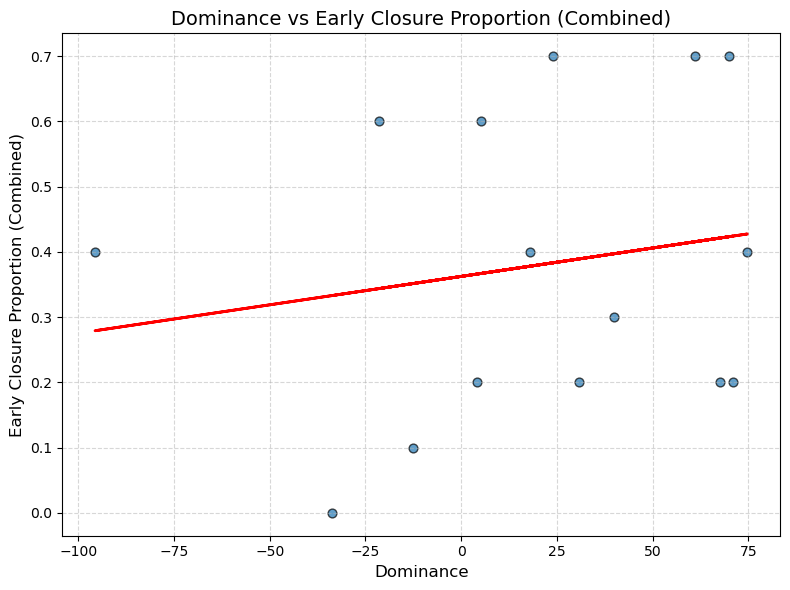

In [8]:
merged_df = pd.read_csv("data/merged.csv")
merged_df['Dominance'] = pd.to_numeric(merged_df['Dominance'], errors='coerce')
merged_df['Early Closure (ES)'] = pd.to_numeric(merged_df['Early Closure (ES)'], errors='coerce')
merged_df['Early Closure (ING)'] = pd.to_numeric(merged_df['Early Closure (ING)'], errors='coerce')

merged_df['Early Closure (Combined)'] = (merged_df['Early Closure (ES)'] + merged_df['Early Closure (ING)']) / 2

plt.figure(figsize=(8, 6))
x = merged_df['Dominance']
y = merged_df['Early Closure (Combined)']
plt.scatter(x, y, s=40, alpha=0.7, edgecolors='k')
m, b = np.polyfit(x.dropna(), y.dropna(), 1)
plt.plot(x, m * x + b, color='red', linewidth=2)
plt.xlabel('Dominance', fontsize=12)
plt.ylabel('Early Closure Proportion (Combined)', fontsize=12)
plt.title('Dominance vs Early Closure Proportion (Combined)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()